In [37]:
import GWPhotonCounting
from GWPhotonCounting.utils import phase_shift, lorentzian_complex
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import bilby


frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))
detector = GWPhotonCounting.detector.Detector(frequencies, 'data/CE1_shot_psd.csv', 'data/CE1_classical_quanta.csv', 
                                              gamma=100, random_seed=1632, N_frequency_spaces=10)

detector_squeeze = GWPhotonCounting.detector.Detector(frequencies, '/home/ethan.payne/code_libraries/bilby/bilby/gw/detector/noise_curves/ce_displacement/cosmic_explorer_ASD.txt', None, detector_asd=True,
                                              gamma=100, random_seed=1632, N_frequency_spaces=10)

In [38]:
KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/home/ethan.payne/code_libraries/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [40]:
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

A_array = []

for mtot in jnp.arange(2.4, 2.8, 0.005):

    mtot_arr = jnp.zeros(KNNModel.time_array.size) + mtot
    hplus = KNNModel.KNN_model.predict(jnp.transpose(jnp.vstack((mtot_arr, KNNModel.time_array))))

    hplus =  phase_shift(hplus, angle = 0)
    hcross = phase_shift(hplus, angle = jnp.pi/2)

    i_array = np.array(range(len(KNNModel.time_array)))
    n_taper_start = (find_peaks(savgol_filter(np.abs(hplus)[:1000], 25,3))[0][4] + find_peaks(savgol_filter(np.abs(hcross)[:1000], 25,3))[0][4])/2

    with np.errstate(divide='ignore'):
        z_start = (n_taper_start/i_array) + n_taper_start/(i_array - n_taper_start)
    sigma = 1/(np.exp(z_start)+1) *(i_array < n_taper_start) + 1*(i_array >= n_taper_start)

    hp_fd, freq_array = bilby.core.utils.nfft(hplus * sigma, sampling_frequency=1e3/(KNNModel.dt_ms))
    hc_fd, freq_array = bilby.core.utils.nfft(hcross * sigma, sampling_frequency=1e3/(KNNModel.dt_ms))

    A_array.append(jnp.max(np.abs(hp_fd)))

In [41]:
jnp.median(jnp.array(A_array))

Array(0.00072841, dtype=float64)

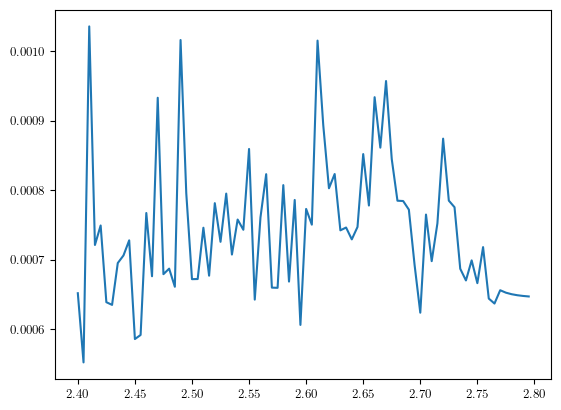

In [42]:
plt.plot(jnp.arange(2.4, 2.8, 0.005), A_array)

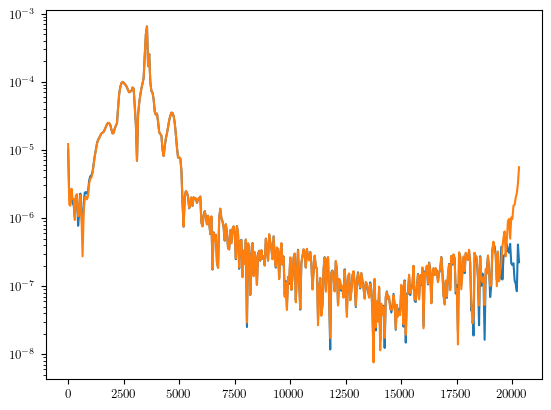

In [45]:
plt.semilogy(freq_array, np.abs(hp_fd))
plt.semilogy(freq_array, np.abs(hc_fd))